In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Các thư viện Scikit-learn (sklearn) cho PHÂN CỤM
from sklearn.preprocessing import StandardScaler # <-- Rất quan trọng
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # <-- Phương pháp đánh giá

# Tắt cảnh báo
import warnings
warnings.filterwarnings('ignore')

# --- Tải Dữ liệu ---
file_path = 'wholesale_customers_data.csv'
df = pd.read_csv(file_path)

# Bỏ cột 'Unnamed: 0' nếu có
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

print("Tải dữ liệu thành công!")
print(df.head())

Tải dữ liệu thành công!
   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


--- Yêu cầu 1: Biểu diễn dữ liệu & Chuẩn bị ---
Sẽ phân cụm dựa trên 6 đặc trưng chi tiêu.


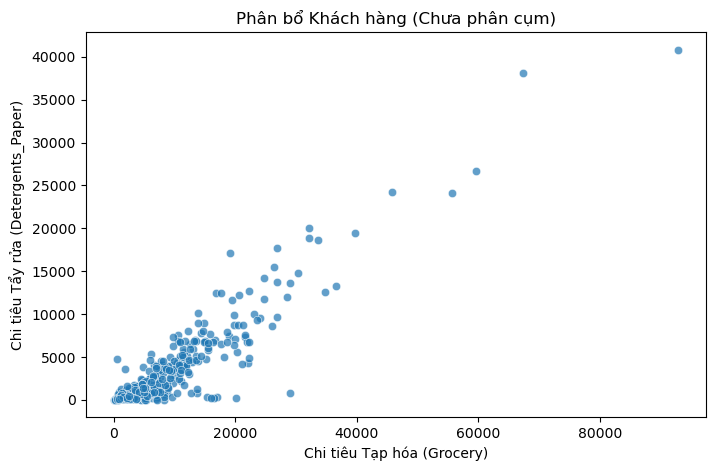


Đã chuẩn hóa (Scale) 6 cột chi tiêu.


In [5]:
print("--- Yêu cầu 1: Biểu diễn dữ liệu & Chuẩn bị ---")

# 1. Tách dữ liệu chi tiêu (X)
# Chúng ta chỉ phân cụm dựa trên 6 cột chi tiêu
spending_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
X = df[spending_features]
print(f"Sẽ phân cụm dựa trên {len(spending_features)} đặc trưng chi tiêu.")

# 2. Biểu diễn dữ liệu (Matplotlib)
# Vẽ biểu đồ 2 cột có vẻ liên quan nhất: Grocery và Detergents_Paper
plt.figure(figsize=(8, 5))
sns.scatterplot(data=X, x='Grocery', y='Detergents_Paper', alpha=0.7)
plt.title('Phân bổ Khách hàng (Chưa phân cụm)')
plt.xlabel('Chi tiêu Tạp hóa (Grocery)')
plt.ylabel('Chi tiêu Tẩy rửa (Detergents_Paper)')
plt.show()

# 3. Chuẩn hóa dữ liệu (Scaling)
# BẮT BUỘC: K-Means dựa trên khoảng cách Euclidean[cite: 40, 3339].
# Các cột (ví dụ: 'Fresh' có max 112k, 'Frozen' có max 60k)
# có thang đo quá khác nhau và sẽ làm hỏng mô hình.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\nĐã chuẩn hóa (Scale) 6 cột chi tiêu.")

--- Yêu cầu 2 & 3: Huấn luyện và Đánh giá (Mô hình K-Means K=3) ---
Đã huấn luyện xong mô hình K-Means với K=3.
Các nhãn cụm đã dự đoán (50 mẫu đầu): [1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 0 1 0 0 0 1 0]


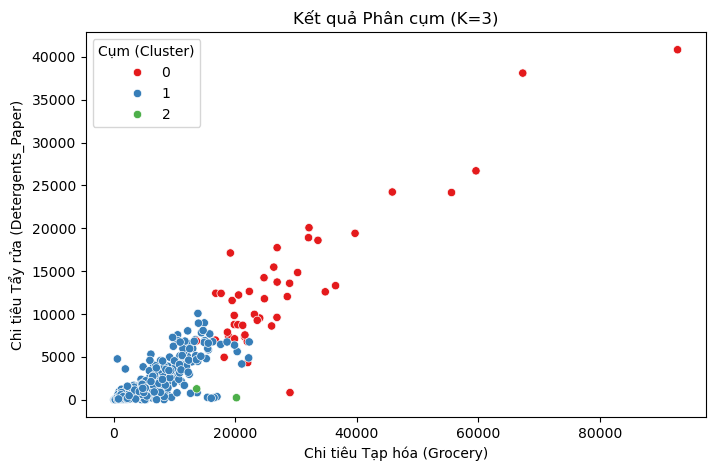


--- Đánh giá chỉ số (Mô hình K=3) ---
Silhouette Score: 0.5483


In [7]:
print("--- Yêu cầu 2 & 3: Huấn luyện và Đánh giá (Mô hình K-Means K=3) ---")

# --- Yêu cầu 2: Huấn luyện mô hình ---
k_baseline = 3
model_kmeans_baseline = KMeans(n_clusters=k_baseline, random_state=42, n_init=10)
# 'n_init=10' để chạy 10 lần và chọn kết quả tốt nhất (tránh local optima )

# Huấn luyện và dự đoán cụm
model_kmeans_baseline.fit(X_scaled)
labels_baseline = model_kmeans_baseline.labels_

print(f"Đã huấn luyện xong mô hình K-Means với K={k_baseline}.")
print(f"Các nhãn cụm đã dự đoán (50 mẫu đầu): {labels_baseline[:50]}")

# --- Yêu cầu 3: Đánh giá mô hình ---
# Vì không có 'y_test', chúng ta đánh giá bằng 2 cách:

# 3.1. Đánh giá bằng Trực quan hóa (Vẽ lại biểu đồ với màu)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=X, x='Grocery', y='Detergents_Paper', 
                hue=labels_baseline, # Tô màu theo nhãn cụm
                palette='Set1')
plt.title(f'Kết quả Phân cụm (K={k_baseline})')
plt.xlabel('Chi tiêu Tạp hóa (Grocery)')
plt.ylabel('Chi tiêu Tẩy rửa (Detergents_Paper)')
plt.legend(title='Cụm (Cluster)')
plt.show()

# 3.2. Đánh giá bằng chỉ số (Silhouette Score)
# Chỉ số này đo lường mức độ "rõ ràng" của các cụm.
# Càng gần 1 càng tốt, càng gần -1 càng tệ.
silhouette_baseline = silhouette_score(X_scaled, labels_baseline)
print(f"\n--- Đánh giá chỉ số (Mô hình K={k_baseline}) ---")
print(f"Silhouette Score: {silhouette_baseline:.4f}")

--- Yêu cầu 4: Tinh chỉnh Mô hình (Tìm K tối ưu bằng Elbow Method) ---
Đang chạy K-Means với K từ 1 đến 10...
Đã chạy xong.


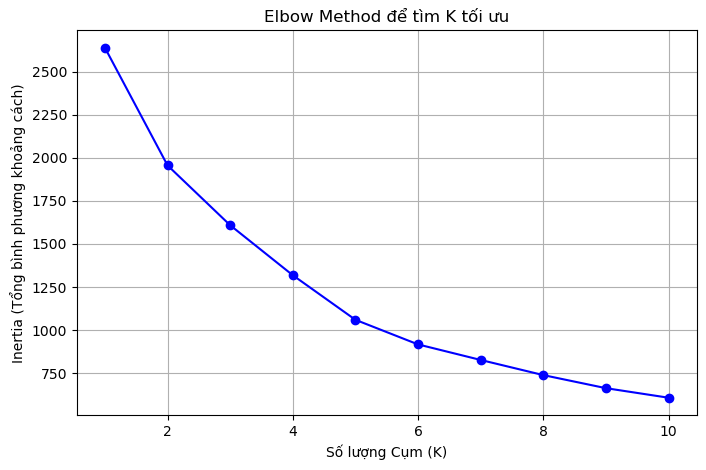

In [9]:
print("--- Yêu cầu 4: Tinh chỉnh Mô hình (Tìm K tối ưu bằng Elbow Method) ---")

# 1. Chạy K-Means với nhiều giá trị K (từ 1 đến 10)
inertia_values = [] # List để lưu trữ 'inertia'
possible_k_values = range(1, 11)

print("Đang chạy K-Means với K từ 1 đến 10...")
for k in possible_k_values:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(X_scaled)
    inertia_values.append(model.inertia_) # 'inertia_' là tổng bình phương khoảng cách
                                        # của các điểm đến tâm cụm gần nhất.

print("Đã chạy xong.")

# 2. Vẽ biểu đồ Elbow (Matplotlib)
plt.figure(figsize=(8, 5))
plt.plot(possible_k_values, inertia_values, 'bo-') # 'bo-' = blue dots with line
plt.title('Elbow Method để tìm K tối ưu')
plt.xlabel('Số lượng Cụm (K)')
plt.ylabel('Inertia (Tổng bình phương khoảng cách)')
plt.grid(True)
plt.show()